# [Lab Session 4](deconvolution.ipynb)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

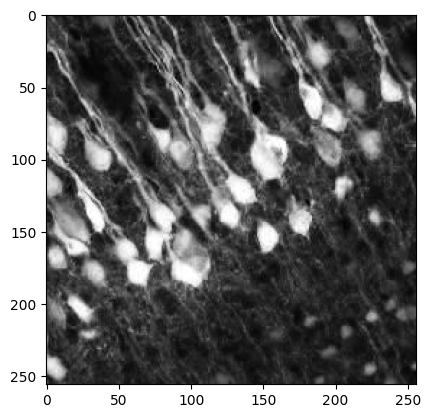

In [48]:
img = plt.imread('data/cells.png')[128:384, 128:384] # schneidet Zeilen und Spalten 128 bis 384 aus dem Bild heraus
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [49]:
psf_size = 10 # Größe des PSF-Kernels (10x10)
psf = np.ones((psf_size, psf_size)) / psf_size ** 2 # Normalisiertes PSF-Kernel -> alles Werte der matrix =1

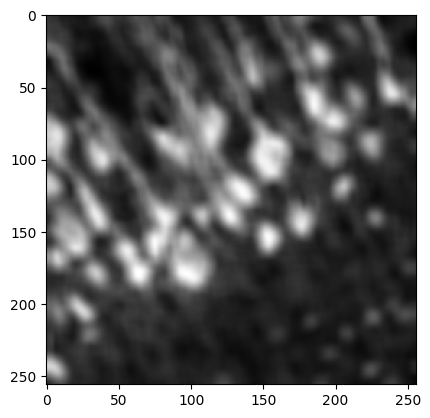

In [50]:
img_psf = conv(img, psf, mode='same', boundary='symm') # Faltung des Bildes mit dem PSF-Kernel (Bild wird verwischt)
plt.imshow(img_psf, 'gray')

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

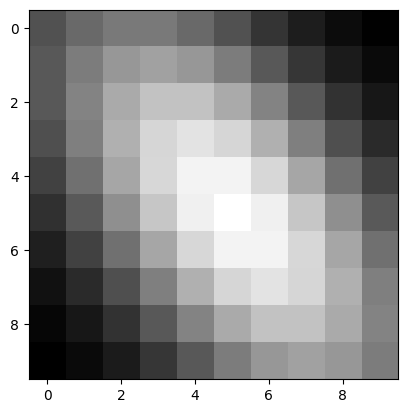

In [51]:
def create_psf(size): # erstellt ein PSF-Kernel basierend auf einer 2D-Gaußverteilung
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

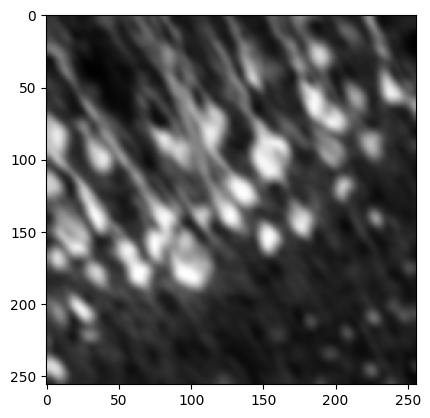

In [52]:
img_blurred_psf = conv(img, create_psf(psf_size), mode='same', boundary='symm') # Faltung des Bildes mit dem Gauß-PSF-Kernel
plt.imshow(img_blurred_psf, 'gray')

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [53]:
def richardson_lucy_deconvolution(image, psf, n_iterations): 
    img_deconv = np.full(image.shape, 0.5) #Schätzwert (0,5)
    for _ in range(n_iterations):
        conv_img = conv(img_deconv, psf, mode='same', boundary='symm') # Faltung des aktuellen Schätzwerts mit dem PSF-Kernel
        relative_blur = image / (conv_img + 1e-7) #Berechnung des Fehlers
        img_deconv *= conv(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm') # Aktualisierung des Schätzwerts
    img_deconv = img_deconv.clip(0,1) #clippen der Werte zwischen 0 und 1
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

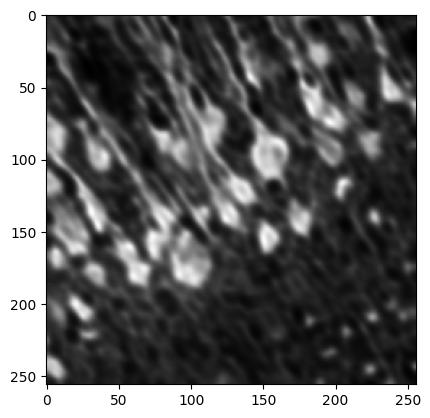

In [54]:
# apply richardson-lucy deconvolution to the blurred image
r_l_deconvolved_img = richardson_lucy_deconvolution(img_blurred_psf, create_psf(psf_size), n_iterations=30)
plt.imshow(r_l_deconvolved_img, 'gray')

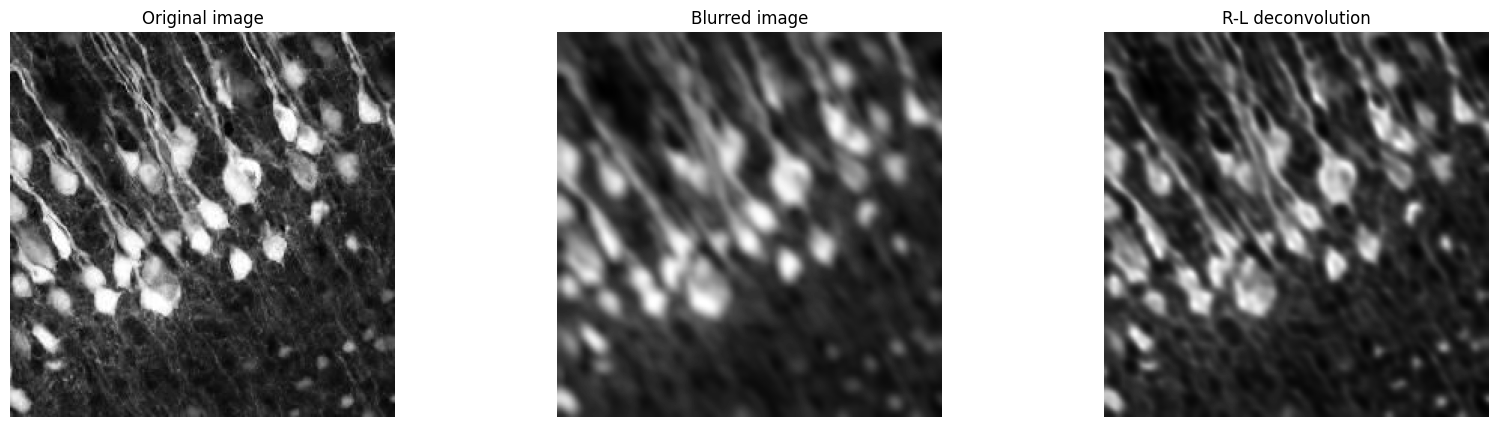

In [55]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_blurred_psf, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(r_l_deconvolved_img, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [56]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

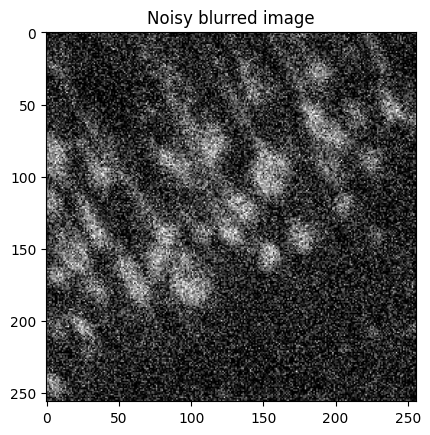

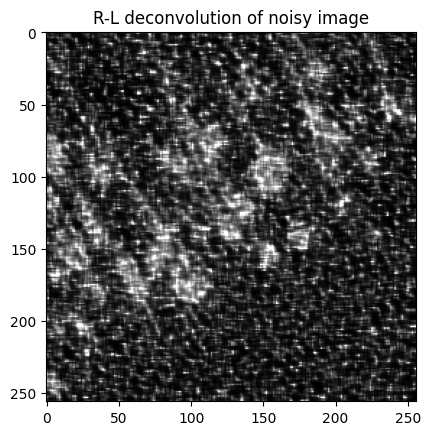

In [57]:
# add noise to the blurred image
noisy_blurred_img = (img_blurred_psf + noise).clip(0,1)
plt.imshow(noisy_blurred_img, 'gray')
plt.title('Noisy blurred image')
plt.show()

# apply richardson-lucy deconvolution to the noisy blurred image
r_l_deconvolved_noisy_img = richardson_lucy_deconvolution(noisy_blurred_img, create_psf(psf_size), n_iterations=30)
plt.imshow(r_l_deconvolved_noisy_img, 'gray')
plt.title('R-L deconvolution of noisy image')
plt.show()

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

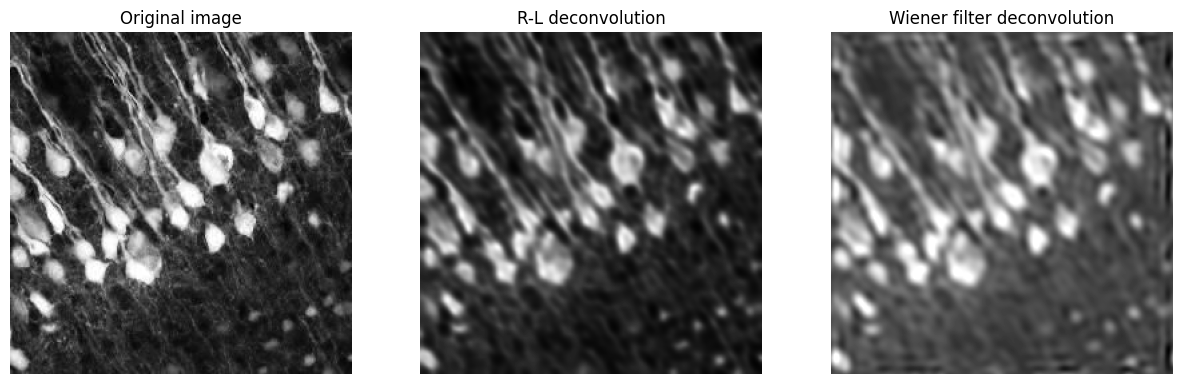

In [58]:
#compare your richardson-lucy implementation with the wiener filter deconvolution
wiener_deconvolved_img = wiener(img_blurred_psf, create_psf(psf_size), balance=0.1)
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(r_l_deconvolved_img, 'gray')
plt.title('R-L deconvolution')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(wiener_deconvolved_img, 'gray')
plt.title('Wiener filter deconvolution')
plt.show()

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

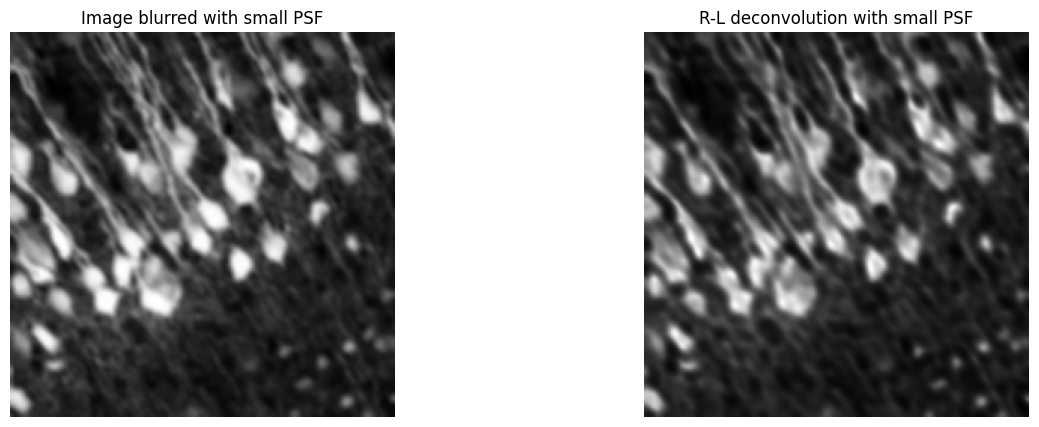

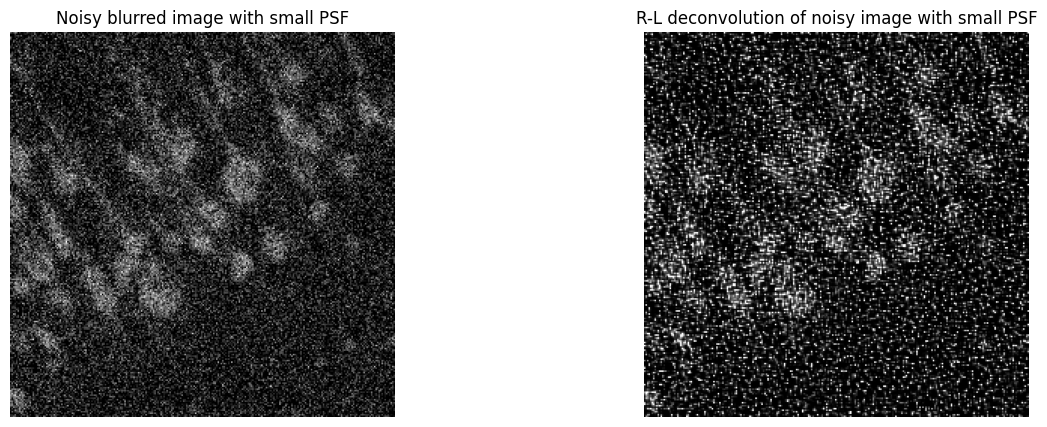

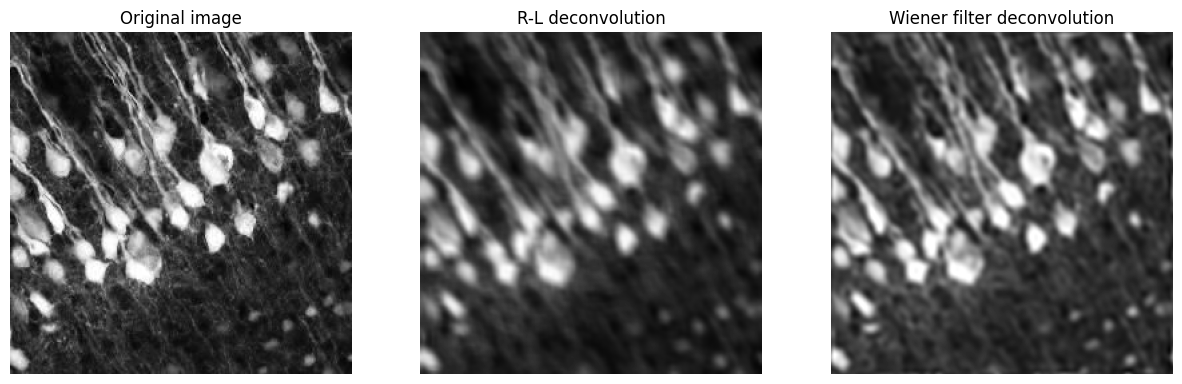

In [59]:
small_psf_size = 5
small_psf = np.ones((small_psf_size, small_psf_size)) / psf_size ** 2

small_img_blurred_psf = conv(img, create_psf(small_psf_size), mode='same', boundary='symm')

# apply richardson-lucy deconvolution to the blurred image
small_r_l_deconvolved_img = richardson_lucy_deconvolution(img_blurred_psf, create_psf(small_psf_size), n_iterations=30)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(small_img_blurred_psf, 'gray')
plt.title('Image blurred with small PSF')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(r_l_deconvolved_img, 'gray')
plt.title('R-L deconvolution with small PSF')
plt.show()

# add noise to the blurred image
small_noisy_blurred_img = (small_img_blurred_psf + noise).clip(0,1)

# apply richardson-lucy deconvolution to the noisy blurred image
small_r_l_deconvolved_noisy_img = richardson_lucy_deconvolution(small_noisy_blurred_img, create_psf(small_psf_size), n_iterations=30)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(small_noisy_blurred_img, 'gray')
plt.title('Noisy blurred image with small PSF')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(small_r_l_deconvolved_noisy_img, 'gray')
plt.title('R-L deconvolution of noisy image with small PSF')
plt.show()


#compare your richardson-lucy implementation with the wiener filter deconvolution
small_wiener_deconvolved_img = wiener(small_img_blurred_psf, create_psf(small_psf_size), balance=0.1)
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(small_r_l_deconvolved_img, 'gray')
plt.title('R-L deconvolution')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(small_wiener_deconvolved_img, 'gray')
plt.title('Wiener filter deconvolution')
plt.show()

**[Task 8.]()** Use a wrong PSF to restore the image

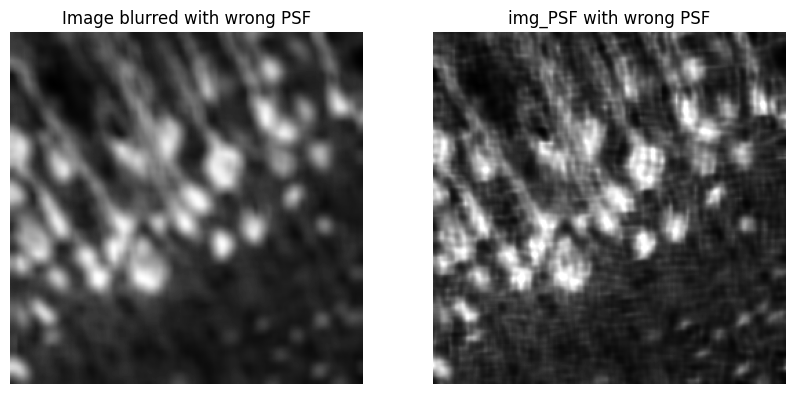

In [60]:
deconv_wrong_psf = richardson_lucy_deconvolution(img_blurred_psf, create_psf(psf_size), n_iterations=100)
deconv_wrong_psf = richardson_lucy_deconvolution(img_psf, create_psf(psf_size), n_iterations=100)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img_psf, 'gray')
plt.title('Image blurred with wrong PSF')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(deconv_wrong_psf, 'gray')
plt.title('img_PSF with wrong PSF')
plt.show()